In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)


        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=5)
        # self.fc5 = nn.Linear(in_features=1024, out_features=5)

         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        # x = F.relu(self.fc4(x))
        # x = self.dropout(x)
        x=self.fc4(x)
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()
# model.load_state_dict(torch.load())

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/last(5+4+dropout)model.pth')

1801413  parameters
Start Training
epoch  1


100%|██████████| 6250/6250 [00:55<00:00, 112.19it/s]


epoch 1 training loss: 1.610
Accuracy of the network on the train images: 20.052000 %


100%|██████████| 625/625 [00:03<00:00, 205.12it/s]


Accuracy of the network on the test images: 20.080000 %
epoch  2


100%|██████████| 6250/6250 [00:45<00:00, 137.97it/s]


epoch 2 training loss: 1.575
Accuracy of the network on the train images: 23.520000 %


100%|██████████| 625/625 [00:03<00:00, 208.20it/s]


Accuracy of the network on the test images: 33.280000 %
epoch  3


100%|██████████| 6250/6250 [00:45<00:00, 137.03it/s]


epoch 3 training loss: 1.284
Accuracy of the network on the train images: 36.132000 %


100%|██████████| 625/625 [00:03<00:00, 205.84it/s]


Accuracy of the network on the test images: 40.240000 %
epoch  4


100%|██████████| 6250/6250 [00:47<00:00, 132.78it/s]


epoch 4 training loss: 1.168
Accuracy of the network on the train images: 43.620000 %


100%|██████████| 625/625 [00:03<00:00, 204.00it/s]


Accuracy of the network on the test images: 47.440000 %
epoch  5


100%|██████████| 6250/6250 [00:45<00:00, 137.61it/s]


epoch 5 training loss: 1.097
Accuracy of the network on the train images: 48.876000 %


100%|██████████| 625/625 [00:03<00:00, 204.22it/s]


Accuracy of the network on the test images: 53.080000 %
epoch  6


100%|██████████| 6250/6250 [00:45<00:00, 136.87it/s]


epoch 6 training loss: 0.999
Accuracy of the network on the train images: 55.564000 %


100%|██████████| 625/625 [00:02<00:00, 208.93it/s]


Accuracy of the network on the test images: 54.360000 %
epoch  7


100%|██████████| 6250/6250 [00:46<00:00, 135.03it/s]


epoch 7 training loss: 0.904
Accuracy of the network on the train images: 61.004000 %


100%|██████████| 625/625 [00:03<00:00, 205.23it/s]


Accuracy of the network on the test images: 63.480000 %
epoch  8


100%|██████████| 6250/6250 [00:45<00:00, 138.28it/s]


epoch 8 training loss: 0.807
Accuracy of the network on the train images: 66.480000 %


100%|██████████| 625/625 [00:02<00:00, 208.74it/s]


Accuracy of the network on the test images: 70.200000 %
epoch  9


100%|██████████| 6250/6250 [00:46<00:00, 134.82it/s]


epoch 9 training loss: 0.720
Accuracy of the network on the train images: 71.200000 %


100%|██████████| 625/625 [00:03<00:00, 205.51it/s]


Accuracy of the network on the test images: 71.080000 %
epoch  10


100%|██████████| 6250/6250 [00:45<00:00, 137.73it/s]


epoch 10 training loss: 0.641
Accuracy of the network on the train images: 75.200000 %


100%|██████████| 625/625 [00:03<00:00, 201.06it/s]


Accuracy of the network on the test images: 74.360000 %
epoch  11


100%|██████████| 6250/6250 [00:45<00:00, 137.04it/s]


epoch 11 training loss: 0.573
Accuracy of the network on the train images: 77.808000 %


100%|██████████| 625/625 [00:03<00:00, 205.36it/s]


Accuracy of the network on the test images: 76.920000 %
epoch  12


100%|██████████| 6250/6250 [00:46<00:00, 134.53it/s]


epoch 12 training loss: 0.505
Accuracy of the network on the train images: 80.832000 %


100%|██████████| 625/625 [00:03<00:00, 205.72it/s]


Accuracy of the network on the test images: 78.840000 %
epoch  13


100%|██████████| 6250/6250 [00:45<00:00, 138.13it/s]


epoch 13 training loss: 0.455
Accuracy of the network on the train images: 82.816000 %


100%|██████████| 625/625 [00:02<00:00, 209.13it/s]


Accuracy of the network on the test images: 78.640000 %
epoch  14


100%|██████████| 6250/6250 [00:44<00:00, 139.38it/s]


epoch 14 training loss: 0.401
Accuracy of the network on the train images: 85.224000 %


100%|██████████| 625/625 [00:04<00:00, 146.45it/s]


Accuracy of the network on the test images: 80.000000 %
epoch  15


100%|██████████| 6250/6250 [00:45<00:00, 138.34it/s]


epoch 15 training loss: 0.354
Accuracy of the network on the train images: 86.956000 %


100%|██████████| 625/625 [00:03<00:00, 207.72it/s]


Accuracy of the network on the test images: 79.760000 %
epoch  16


100%|██████████| 6250/6250 [00:45<00:00, 138.42it/s]


epoch 16 training loss: 0.305
Accuracy of the network on the train images: 88.828000 %


100%|██████████| 625/625 [00:03<00:00, 207.71it/s]


Accuracy of the network on the test images: 79.120000 %
epoch  17


100%|██████████| 6250/6250 [00:46<00:00, 134.08it/s]


epoch 17 training loss: 0.265
Accuracy of the network on the train images: 90.320000 %


100%|██████████| 625/625 [00:03<00:00, 203.87it/s]


Accuracy of the network on the test images: 79.920000 %
epoch  18


100%|██████████| 6250/6250 [00:44<00:00, 139.10it/s]


epoch 18 training loss: 0.231
Accuracy of the network on the train images: 91.788000 %


100%|██████████| 625/625 [00:02<00:00, 209.37it/s]


Accuracy of the network on the test images: 81.680000 %
epoch  19


100%|██████████| 6250/6250 [00:44<00:00, 139.47it/s]


epoch 19 training loss: 0.205
Accuracy of the network on the train images: 92.868000 %


100%|██████████| 625/625 [00:03<00:00, 205.21it/s]


Accuracy of the network on the test images: 80.560000 %
epoch  20


100%|██████████| 6250/6250 [00:46<00:00, 135.70it/s]


epoch 20 training loss: 0.182
Accuracy of the network on the train images: 93.672000 %


100%|██████████| 625/625 [00:02<00:00, 209.89it/s]


Accuracy of the network on the test images: 80.200000 %
epoch  21


100%|██████████| 6250/6250 [00:45<00:00, 138.80it/s]


epoch 21 training loss: 0.160
Accuracy of the network on the train images: 94.364000 %


100%|██████████| 625/625 [00:03<00:00, 207.08it/s]


Accuracy of the network on the test images: 80.600000 %
epoch  22


100%|██████████| 6250/6250 [00:45<00:00, 136.12it/s]


epoch 22 training loss: 0.137
Accuracy of the network on the train images: 95.232000 %


100%|██████████| 625/625 [00:02<00:00, 208.35it/s]


Accuracy of the network on the test images: 79.960000 %
epoch  23


100%|██████████| 6250/6250 [00:45<00:00, 137.78it/s]


epoch 23 training loss: 0.126
Accuracy of the network on the train images: 95.696000 %


100%|██████████| 625/625 [00:02<00:00, 211.06it/s]


Accuracy of the network on the test images: 80.680000 %
epoch  24


100%|██████████| 6250/6250 [00:44<00:00, 139.42it/s]


epoch 24 training loss: 0.112
Accuracy of the network on the train images: 96.212000 %


100%|██████████| 625/625 [00:03<00:00, 207.49it/s]


Accuracy of the network on the test images: 80.480000 %
epoch  25


100%|██████████| 6250/6250 [00:46<00:00, 135.38it/s]


epoch 25 training loss: 0.107
Accuracy of the network on the train images: 96.380000 %


100%|██████████| 625/625 [00:02<00:00, 209.63it/s]


Accuracy of the network on the test images: 80.560000 %
epoch  26


100%|██████████| 6250/6250 [00:45<00:00, 138.72it/s]


epoch 26 training loss: 0.093
Accuracy of the network on the train images: 96.728000 %


100%|██████████| 625/625 [00:02<00:00, 209.30it/s]


Accuracy of the network on the test images: 79.000000 %
epoch  27


100%|██████████| 6250/6250 [00:44<00:00, 139.90it/s]


epoch 27 training loss: 0.094
Accuracy of the network on the train images: 96.804000 %


100%|██████████| 625/625 [00:03<00:00, 183.08it/s]


Accuracy of the network on the test images: 81.520000 %
epoch  28


100%|██████████| 6250/6250 [00:46<00:00, 135.73it/s]


epoch 28 training loss: 0.084
Accuracy of the network on the train images: 97.336000 %


100%|██████████| 625/625 [00:02<00:00, 209.82it/s]


Accuracy of the network on the test images: 79.680000 %
epoch  29


100%|██████████| 6250/6250 [00:44<00:00, 139.51it/s]


epoch 29 training loss: 0.073
Accuracy of the network on the train images: 97.516000 %


100%|██████████| 625/625 [00:03<00:00, 204.09it/s]


Accuracy of the network on the test images: 80.640000 %
epoch  30


100%|██████████| 6250/6250 [00:46<00:00, 134.22it/s]


epoch 30 training loss: 0.067
Accuracy of the network on the train images: 97.820000 %


100%|██████████| 625/625 [00:02<00:00, 208.72it/s]


Accuracy of the network on the test images: 78.200000 %
epoch  31


100%|██████████| 6250/6250 [00:44<00:00, 139.83it/s]


epoch 31 training loss: 0.072
Accuracy of the network on the train images: 97.544000 %


100%|██████████| 625/625 [00:02<00:00, 210.10it/s]


Accuracy of the network on the test images: 81.280000 %
epoch  32


100%|██████████| 6250/6250 [00:44<00:00, 139.61it/s]


epoch 32 training loss: 0.062
Accuracy of the network on the train images: 97.908000 %


100%|██████████| 625/625 [00:03<00:00, 204.34it/s]


Accuracy of the network on the test images: 80.440000 %
epoch  33


100%|██████████| 6250/6250 [00:46<00:00, 133.87it/s]


epoch 33 training loss: 0.065
Accuracy of the network on the train images: 97.828000 %


100%|██████████| 625/625 [00:03<00:00, 208.32it/s]


Accuracy of the network on the test images: 81.280000 %
epoch  34


100%|██████████| 6250/6250 [00:45<00:00, 138.66it/s]


epoch 34 training loss: 0.062
Accuracy of the network on the train images: 97.964000 %


100%|██████████| 625/625 [00:02<00:00, 208.55it/s]


Accuracy of the network on the test images: 80.480000 %
epoch  35


100%|██████████| 6250/6250 [00:46<00:00, 135.15it/s]


epoch 35 training loss: 0.060
Accuracy of the network on the train images: 98.088000 %


100%|██████████| 625/625 [00:02<00:00, 210.76it/s]


Accuracy of the network on the test images: 80.800000 %
epoch  36


100%|██████████| 6250/6250 [00:45<00:00, 137.08it/s]


epoch 36 training loss: 0.057
Accuracy of the network on the train images: 98.156000 %


100%|██████████| 625/625 [00:02<00:00, 209.18it/s]


Accuracy of the network on the test images: 79.960000 %
epoch  37


100%|██████████| 6250/6250 [00:44<00:00, 139.63it/s]


epoch 37 training loss: 0.051
Accuracy of the network on the train images: 98.372000 %


100%|██████████| 625/625 [00:03<00:00, 201.99it/s]


Accuracy of the network on the test images: 81.320000 %
epoch  38


100%|██████████| 6250/6250 [00:46<00:00, 134.58it/s]


epoch 38 training loss: 0.055
Accuracy of the network on the train images: 98.200000 %


100%|██████████| 625/625 [00:03<00:00, 206.97it/s]


Accuracy of the network on the test images: 82.200000 %
epoch  39


100%|██████████| 6250/6250 [00:45<00:00, 137.75it/s]


epoch 39 training loss: 0.059
Accuracy of the network on the train images: 98.004000 %


100%|██████████| 625/625 [00:03<00:00, 205.41it/s]


Accuracy of the network on the test images: 79.920000 %
epoch  40


100%|██████████| 6250/6250 [00:44<00:00, 138.96it/s]


epoch 40 training loss: 0.054
Accuracy of the network on the train images: 98.200000 %


100%|██████████| 625/625 [00:04<00:00, 151.95it/s]


Accuracy of the network on the test images: 80.240000 %
epoch  41


100%|██████████| 6250/6250 [00:45<00:00, 138.81it/s]


epoch 41 training loss: 0.051
Accuracy of the network on the train images: 98.376000 %


100%|██████████| 625/625 [00:02<00:00, 210.57it/s]


Accuracy of the network on the test images: 81.520000 %
epoch  42


100%|██████████| 6250/6250 [00:45<00:00, 137.60it/s]


epoch 42 training loss: 0.058
Accuracy of the network on the train images: 98.044000 %


100%|██████████| 625/625 [00:03<00:00, 206.15it/s]


Accuracy of the network on the test images: 80.080000 %
epoch  43


100%|██████████| 6250/6250 [00:45<00:00, 135.89it/s]


epoch 43 training loss: 0.055
Accuracy of the network on the train images: 98.088000 %


100%|██████████| 625/625 [00:03<00:00, 205.81it/s]


Accuracy of the network on the test images: 82.200000 %
epoch  44


100%|██████████| 6250/6250 [00:45<00:00, 138.23it/s]


epoch 44 training loss: 0.040
Accuracy of the network on the train images: 98.656000 %


100%|██████████| 625/625 [00:03<00:00, 207.53it/s]


Accuracy of the network on the test images: 81.360000 %
epoch  45


100%|██████████| 6250/6250 [00:44<00:00, 139.17it/s]


epoch 45 training loss: 0.054
Accuracy of the network on the train images: 98.192000 %


100%|██████████| 625/625 [00:03<00:00, 206.44it/s]


Accuracy of the network on the test images: 80.240000 %
epoch  46


100%|██████████| 6250/6250 [00:46<00:00, 134.82it/s]


epoch 46 training loss: 0.048
Accuracy of the network on the train images: 98.496000 %


100%|██████████| 625/625 [00:02<00:00, 210.55it/s]


Accuracy of the network on the test images: 81.960000 %
epoch  47


100%|██████████| 6250/6250 [00:44<00:00, 139.20it/s]


epoch 47 training loss: 0.045
Accuracy of the network on the train images: 98.488000 %


100%|██████████| 625/625 [00:03<00:00, 207.83it/s]


Accuracy of the network on the test images: 81.840000 %
epoch  48


100%|██████████| 6250/6250 [00:46<00:00, 135.38it/s]


epoch 48 training loss: 0.045
Accuracy of the network on the train images: 98.464000 %


100%|██████████| 625/625 [00:02<00:00, 210.43it/s]


Accuracy of the network on the test images: 79.840000 %
epoch  49


100%|██████████| 6250/6250 [00:45<00:00, 136.13it/s]


epoch 49 training loss: 0.045
Accuracy of the network on the train images: 98.552000 %


100%|██████████| 625/625 [00:03<00:00, 208.22it/s]


Accuracy of the network on the test images: 81.520000 %
epoch  50


100%|██████████| 6250/6250 [00:44<00:00, 140.15it/s]


epoch 50 training loss: 0.048
Accuracy of the network on the train images: 98.368000 %


100%|██████████| 625/625 [00:02<00:00, 210.12it/s]


Accuracy of the network on the test images: 82.000000 %
performing test


100%|██████████| 625/625 [00:03<00:00, 207.78it/s]


Accuracy of the network on the test images: 80.000000 %


100%|██████████| 625/625 [00:03<00:00, 206.56it/s]

Accuracy of  aeroplane : 84.600000 %
Accuracy of       bird : 80.800000 %
Accuracy of        cat : 64.600000 %
Accuracy of        dog : 82.400000 %
Accuracy of       ship : 87.800000 %
Finished Training


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
!unzip '/content/gdrive/MyDrive/2.zip'
# extracts the files on colab virtual machine

import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random




transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])


train_data_dir = "/content/1/train"

val_data_dir = "/content/1/val"
test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 
trainset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
#divide the data into batches with batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
print(len(trainset))

valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valnset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


Streaming output truncated to the last 5000 lines.
 extracting: 1/train/bird/pipit_s_000192.png  
 extracting: 1/train/bird/flightless_bird_s_000562.png  
 extracting: 1/train/bird/passerine_s_001221.png  
 extracting: 1/train/bird/struthio_camelus_s_000008.png  
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird_s_000353.png  
 extracting: 1/train/bird/pipit_s_000443.png  
 extracting: 1/train/bird/ostrich_s_000506.png  
  inflating: 1/train/bird/sparrow_s_000490.png  
  inflating: 1/train/bird/ostrich_s_002057.png  
  inflating: 1/train/bird/meadow_pipit_s_000610.png  
 extracting: 1/train/bird/cassowary_s_001833.png  
 extracting: 1/train/bird/flying_

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)


        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=1024)
        self.fc5 = nn.Linear(in_features=1024, out_features=5)

         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x=self.fc5(x)
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()
model.load_state_dict(torch.load())

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/last.pth')

2311685  parameters
Start Training
epoch  1


100%|██████████| 6250/6250 [00:53<00:00, 117.92it/s]


epoch 1 training loss: 1.610
Accuracy of the network on the train images: 19.964000 %


100%|██████████| 625/625 [00:03<00:00, 207.73it/s]


Accuracy of the network on the test images: 20.200000 %
epoch  2


100%|██████████| 6250/6250 [00:46<00:00, 135.35it/s]


epoch 2 training loss: 1.523
Accuracy of the network on the train images: 26.292000 %


100%|██████████| 625/625 [00:03<00:00, 204.73it/s]


Accuracy of the network on the test images: 34.240000 %
epoch  3


100%|██████████| 6250/6250 [00:44<00:00, 139.74it/s]


epoch 3 training loss: 1.258
Accuracy of the network on the train images: 37.532000 %


100%|██████████| 625/625 [00:03<00:00, 206.31it/s]


Accuracy of the network on the test images: 41.440000 %
epoch  4


100%|██████████| 6250/6250 [00:46<00:00, 135.57it/s]


epoch 4 training loss: 1.185
Accuracy of the network on the train images: 41.948000 %


100%|██████████| 625/625 [00:03<00:00, 204.44it/s]


Accuracy of the network on the test images: 41.640000 %
epoch  5


100%|██████████| 6250/6250 [00:44<00:00, 140.06it/s]


epoch 5 training loss: 1.125
Accuracy of the network on the train images: 47.168000 %


100%|██████████| 625/625 [00:03<00:00, 203.16it/s]


Accuracy of the network on the test images: 49.280000 %
epoch  6


100%|██████████| 6250/6250 [00:46<00:00, 135.77it/s]


epoch 6 training loss: 1.083
Accuracy of the network on the train images: 50.040000 %


100%|██████████| 625/625 [00:03<00:00, 191.12it/s]


Accuracy of the network on the test images: 53.480000 %
epoch  7


100%|██████████| 6250/6250 [00:45<00:00, 137.48it/s]


epoch 7 training loss: 1.037
Accuracy of the network on the train images: 53.208000 %


100%|██████████| 625/625 [00:03<00:00, 204.37it/s]


Accuracy of the network on the test images: 55.160000 %
epoch  8


100%|██████████| 6250/6250 [00:45<00:00, 138.85it/s]


epoch 8 training loss: 0.990
Accuracy of the network on the train images: 56.124000 %


100%|██████████| 625/625 [00:03<00:00, 208.17it/s]


Accuracy of the network on the test images: 58.480000 %
epoch  9


100%|██████████| 6250/6250 [00:49<00:00, 125.90it/s]


epoch 9 training loss: 0.945
Accuracy of the network on the train images: 58.512000 %


100%|██████████| 625/625 [00:03<00:00, 207.65it/s]


Accuracy of the network on the test images: 60.040000 %
epoch  10


100%|██████████| 6250/6250 [00:44<00:00, 139.97it/s]


epoch 10 training loss: 0.904
Accuracy of the network on the train images: 60.772000 %


100%|██████████| 625/625 [00:03<00:00, 205.75it/s]


Accuracy of the network on the test images: 64.040000 %
epoch  11


100%|██████████| 6250/6250 [00:45<00:00, 137.28it/s]


epoch 11 training loss: 0.856
Accuracy of the network on the train images: 62.900000 %


100%|██████████| 625/625 [00:03<00:00, 205.50it/s]


Accuracy of the network on the test images: 57.320000 %
epoch  12


100%|██████████| 6250/6250 [00:44<00:00, 140.14it/s]


epoch 12 training loss: 0.803
Accuracy of the network on the train images: 66.048000 %


100%|██████████| 625/625 [00:03<00:00, 206.86it/s]


Accuracy of the network on the test images: 67.120000 %
epoch  13


100%|██████████| 6250/6250 [00:46<00:00, 134.43it/s]


epoch 13 training loss: 0.752
Accuracy of the network on the train images: 68.928000 %


100%|██████████| 625/625 [00:03<00:00, 206.47it/s]


Accuracy of the network on the test images: 69.680000 %
epoch  14


100%|██████████| 6250/6250 [00:44<00:00, 139.56it/s]


epoch 14 training loss: 0.691
Accuracy of the network on the train images: 72.416000 %


100%|██████████| 625/625 [00:03<00:00, 207.27it/s]


Accuracy of the network on the test images: 71.880000 %
epoch  15


100%|██████████| 6250/6250 [00:45<00:00, 136.53it/s]


epoch 15 training loss: 0.633
Accuracy of the network on the train images: 74.948000 %


100%|██████████| 625/625 [00:03<00:00, 207.44it/s]


Accuracy of the network on the test images: 75.360000 %
epoch  16


100%|██████████| 6250/6250 [00:44<00:00, 139.71it/s]


epoch 16 training loss: 0.577
Accuracy of the network on the train images: 78.004000 %


100%|██████████| 625/625 [00:03<00:00, 208.24it/s]


Accuracy of the network on the test images: 77.360000 %
epoch  17


100%|██████████| 6250/6250 [00:44<00:00, 140.63it/s]


epoch 17 training loss: 0.526
Accuracy of the network on the train images: 79.916000 %


100%|██████████| 625/625 [00:03<00:00, 205.31it/s]


Accuracy of the network on the test images: 75.040000 %
epoch  18


100%|██████████| 6250/6250 [00:45<00:00, 137.16it/s]


epoch 18 training loss: 0.480
Accuracy of the network on the train images: 82.096000 %


100%|██████████| 625/625 [00:02<00:00, 209.00it/s]


Accuracy of the network on the test images: 74.200000 %
epoch  19


100%|██████████| 6250/6250 [00:44<00:00, 140.65it/s]


epoch 19 training loss: 0.437
Accuracy of the network on the train images: 83.656000 %


100%|██████████| 625/625 [00:02<00:00, 210.37it/s]


Accuracy of the network on the test images: 76.760000 %
epoch  20


100%|██████████| 6250/6250 [00:46<00:00, 135.05it/s]


epoch 20 training loss: 0.394
Accuracy of the network on the train images: 85.456000 %


100%|██████████| 625/625 [00:02<00:00, 209.88it/s]


Accuracy of the network on the test images: 77.800000 %
epoch  21


100%|██████████| 6250/6250 [00:44<00:00, 141.48it/s]


epoch 21 training loss: 0.347
Accuracy of the network on the train images: 87.408000 %


100%|██████████| 625/625 [00:02<00:00, 210.72it/s]


Accuracy of the network on the test images: 80.840000 %
epoch  22


100%|██████████| 6250/6250 [00:45<00:00, 137.48it/s]


epoch 22 training loss: 0.307
Accuracy of the network on the train images: 88.796000 %


100%|██████████| 625/625 [00:02<00:00, 208.42it/s]


Accuracy of the network on the test images: 82.240000 %
epoch  23


100%|██████████| 6250/6250 [00:44<00:00, 141.72it/s]


epoch 23 training loss: 0.283
Accuracy of the network on the train images: 89.776000 %


100%|██████████| 625/625 [00:03<00:00, 207.15it/s]


Accuracy of the network on the test images: 80.840000 %
epoch  24


100%|██████████| 6250/6250 [00:44<00:00, 140.98it/s]


epoch 24 training loss: 0.249
Accuracy of the network on the train images: 91.032000 %


100%|██████████| 625/625 [00:02<00:00, 210.68it/s]


Accuracy of the network on the test images: 81.360000 %
epoch  25


100%|██████████| 6250/6250 [00:45<00:00, 137.61it/s]


epoch 25 training loss: 0.226
Accuracy of the network on the train images: 92.032000 %


100%|██████████| 625/625 [00:02<00:00, 211.84it/s]


Accuracy of the network on the test images: 78.680000 %
epoch  26


100%|██████████| 6250/6250 [00:44<00:00, 140.09it/s]


epoch 26 training loss: 0.195
Accuracy of the network on the train images: 93.300000 %


100%|██████████| 625/625 [00:03<00:00, 208.09it/s]


Accuracy of the network on the test images: 81.760000 %
epoch  27


100%|██████████| 6250/6250 [00:54<00:00, 115.13it/s]


epoch 27 training loss: 0.180
Accuracy of the network on the train images: 93.592000 %


100%|██████████| 625/625 [00:03<00:00, 207.72it/s]


Accuracy of the network on the test images: 83.520000 %
epoch  28


100%|██████████| 6250/6250 [00:44<00:00, 141.50it/s]


epoch 28 training loss: 0.162
Accuracy of the network on the train images: 94.408000 %


100%|██████████| 625/625 [00:03<00:00, 206.99it/s]


Accuracy of the network on the test images: 80.880000 %
epoch  29


100%|██████████| 6250/6250 [00:46<00:00, 133.95it/s]


epoch 29 training loss: 0.142
Accuracy of the network on the train images: 95.212000 %


100%|██████████| 625/625 [00:02<00:00, 210.24it/s]


Accuracy of the network on the test images: 80.760000 %
epoch  30


100%|██████████| 6250/6250 [00:44<00:00, 141.87it/s]


epoch 30 training loss: 0.133
Accuracy of the network on the train images: 95.528000 %


100%|██████████| 625/625 [00:03<00:00, 205.22it/s]


Accuracy of the network on the test images: 82.400000 %
epoch  31


100%|██████████| 6250/6250 [00:45<00:00, 137.26it/s]


epoch 31 training loss: 0.116
Accuracy of the network on the train images: 96.124000 %


100%|██████████| 625/625 [00:02<00:00, 210.29it/s]


Accuracy of the network on the test images: 82.080000 %
epoch  32


100%|██████████| 6250/6250 [00:55<00:00, 112.84it/s]


epoch 32 training loss: 0.115
Accuracy of the network on the train images: 96.228000 %


100%|██████████| 625/625 [00:03<00:00, 207.13it/s]


Accuracy of the network on the test images: 80.960000 %
epoch  33


100%|██████████| 6250/6250 [00:48<00:00, 130.09it/s]


epoch 33 training loss: 0.104
Accuracy of the network on the train images: 96.512000 %


100%|██████████| 625/625 [00:03<00:00, 206.07it/s]


Accuracy of the network on the test images: 82.920000 %
epoch  34


100%|██████████| 6250/6250 [00:45<00:00, 137.99it/s]


epoch 34 training loss: 0.091
Accuracy of the network on the train images: 96.972000 %


100%|██████████| 625/625 [00:03<00:00, 208.28it/s]


Accuracy of the network on the test images: 80.160000 %
epoch  35


100%|██████████| 6250/6250 [00:44<00:00, 140.25it/s]


epoch 35 training loss: 0.088
Accuracy of the network on the train images: 97.008000 %


100%|██████████| 625/625 [00:03<00:00, 204.91it/s]


Accuracy of the network on the test images: 84.040000 %
epoch  36


100%|██████████| 6250/6250 [00:52<00:00, 118.74it/s]


epoch 36 training loss: 0.089
Accuracy of the network on the train images: 97.080000 %


100%|██████████| 625/625 [00:03<00:00, 207.69it/s]


Accuracy of the network on the test images: 82.760000 %
epoch  37


100%|██████████| 6250/6250 [00:48<00:00, 129.19it/s]


epoch 37 training loss: 0.083
Accuracy of the network on the train images: 97.212000 %


100%|██████████| 625/625 [00:03<00:00, 168.99it/s]


Accuracy of the network on the test images: 81.320000 %
epoch  38


100%|██████████| 6250/6250 [00:55<00:00, 111.94it/s]


epoch 38 training loss: 0.073
Accuracy of the network on the train images: 97.624000 %


100%|██████████| 625/625 [00:03<00:00, 204.82it/s]


Accuracy of the network on the test images: 83.480000 %
epoch  39


100%|██████████| 6250/6250 [00:45<00:00, 138.28it/s]


epoch 39 training loss: 0.068
Accuracy of the network on the train images: 97.716000 %


100%|██████████| 625/625 [00:03<00:00, 171.38it/s]


Accuracy of the network on the test images: 81.320000 %
epoch  40


100%|██████████| 6250/6250 [00:49<00:00, 126.74it/s]


epoch 40 training loss: 0.070
Accuracy of the network on the train images: 97.732000 %


100%|██████████| 625/625 [00:03<00:00, 204.87it/s]


Accuracy of the network on the test images: 83.400000 %
epoch  41


100%|██████████| 6250/6250 [00:44<00:00, 140.54it/s]


epoch 41 training loss: 0.064
Accuracy of the network on the train images: 97.916000 %


100%|██████████| 625/625 [00:03<00:00, 206.44it/s]


Accuracy of the network on the test images: 81.960000 %
epoch  42


100%|██████████| 6250/6250 [00:46<00:00, 134.13it/s]


epoch 42 training loss: 0.067
Accuracy of the network on the train images: 97.820000 %


100%|██████████| 625/625 [00:03<00:00, 208.15it/s]


Accuracy of the network on the test images: 82.720000 %
epoch  43


100%|██████████| 6250/6250 [00:44<00:00, 140.41it/s]


epoch 43 training loss: 0.067
Accuracy of the network on the train images: 97.864000 %


100%|██████████| 625/625 [00:02<00:00, 208.83it/s]


Accuracy of the network on the test images: 83.440000 %
epoch  44


100%|██████████| 6250/6250 [00:45<00:00, 137.22it/s]


epoch 44 training loss: 0.059
Accuracy of the network on the train images: 98.084000 %


100%|██████████| 625/625 [00:03<00:00, 201.85it/s]


Accuracy of the network on the test images: 81.080000 %
epoch  45


100%|██████████| 6250/6250 [00:44<00:00, 139.19it/s]


epoch 45 training loss: 0.057
Accuracy of the network on the train images: 98.128000 %


100%|██████████| 625/625 [00:03<00:00, 206.83it/s]


Accuracy of the network on the test images: 82.560000 %
epoch  46


100%|██████████| 6250/6250 [00:44<00:00, 140.41it/s]


epoch 46 training loss: 0.055
Accuracy of the network on the train images: 98.256000 %


100%|██████████| 625/625 [00:04<00:00, 149.47it/s]


Accuracy of the network on the test images: 84.360000 %
epoch  47


100%|██████████| 6250/6250 [00:44<00:00, 140.67it/s]


epoch 47 training loss: 0.050
Accuracy of the network on the train images: 98.408000 %


100%|██████████| 625/625 [00:02<00:00, 208.57it/s]


Accuracy of the network on the test images: 81.760000 %
epoch  48


100%|██████████| 6250/6250 [00:44<00:00, 141.20it/s]


epoch 48 training loss: 0.057
Accuracy of the network on the train images: 98.148000 %


100%|██████████| 625/625 [00:02<00:00, 209.11it/s]


Accuracy of the network on the test images: 84.320000 %
epoch  49


100%|██████████| 6250/6250 [00:45<00:00, 138.35it/s]


epoch 49 training loss: 0.049
Accuracy of the network on the train images: 98.372000 %


100%|██████████| 625/625 [00:03<00:00, 208.31it/s]


Accuracy of the network on the test images: 82.720000 %
epoch  50


100%|██████████| 6250/6250 [00:44<00:00, 141.27it/s]


epoch 50 training loss: 0.051
Accuracy of the network on the train images: 98.280000 %


100%|██████████| 625/625 [00:03<00:00, 207.48it/s]


Accuracy of the network on the test images: 83.520000 %
performing test


100%|██████████| 625/625 [00:02<00:00, 211.77it/s]


Accuracy of the network on the test images: 81.720000 %


100%|██████████| 625/625 [00:02<00:00, 208.84it/s]

Accuracy of  aeroplane : 88.000000 %
Accuracy of       bird : 73.000000 %
Accuracy of        cat : 84.000000 %
Accuracy of        dog : 73.800000 %
Accuracy of       ship : 92.400000 %
Finished Training


50
50


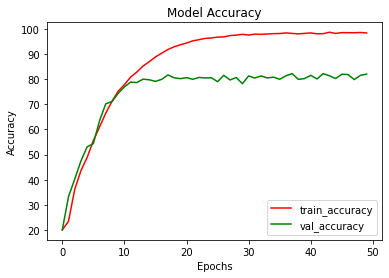

In [ ]:
print(len(train_accuracies))
print(len(val_accuracies))
with open(r'trainconv5+fc4+dropout.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)
with open(r'valconv5+fc4+drop.txt', 'w') as fp:
  for item in val_accuracies:
     fp.write("%s\n" % item)
     epochs= np.arange(0, 50, 1)
  
# Assign variables to the y axis part of the curve
y = train_accuracies
z = val_accuracies
  
# Plotting both the curves simultaneously
plt.plot(epochs, y, color='r', label='train_accuracy')
plt.plot(epochs, z, color='g', label='val_accuracy')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()